In [ ]:
from google.colab import files
files.upload()

# Create WordCloud

In [ ]:
import pandas as pd
df=pd.read_json('data_latih.json')

df.head()

,akun,id_user,isi,sentimen,tanggal
0,@AhokDjarot,823082326213021696,RT @AhokDjarot: Penasaran sama #BasukiDjarot? ...,netral,Tue Apr 04 14:04:05 +0000 2017
1,@AhokDjarot,3166296157,@AhokDjarot Melayani warga jakarta mulai dari ...,positif,Tue Apr 04 14:00:01 +0000 2017
2,@AhokDjarot,799108167170949121,@Lintank01 @AhokDjarot Golongan sumbu pendek l...,negatif,Tue Apr 04 13:56:37 +0000 2017
3,@AhokDjarot,710566116553166849,RT @RahyaMaya: https://t.co/pvVUIp3YYw Pak Aho...,positif,Tue Apr 04 13:52:44 +0000 2017
4,@AhokDjarot,1335669534,Prof. Edward Omar Sharif H. (Ahli Pidana) : Me...,positif,Tue Apr 04 13:50:01 +0000 2017


In [ ]:
df.drop(['akun','id_user','tanggal'],axis=1,inplace=True)

In [ ]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
import re

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()
    

clean_tweet_texts = []
for i in range(650):                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['isi'][i]))

In [ ]:
clean_df=pd.DataFrame(clean_tweet_texts,columns=['isi'])
clean_df['sentimen'] = df.sentimen

In [ ]:
tweet_pos=clean_df[clean_df.sentimen == 'positif']
tweet_neg=clean_df[clean_df.sentimen=='negatif']
tweet_netral=clean_df[clean_df.sentimen=='netral']

In [ ]:
join_pos = ' '.join(tweet_pos['isi'].to_list())
join_neg = ' '.join(tweet_neg['isi'].to_list())
join_netral = ' '.join(tweet_netral['isi'].to_list())

In [ ]:
import nltk
from nltk import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
token_pos=word_tokenize(join_pos)
token_netral=word_tokenize(join_neg)
token_neg=word_tokenize(join_netral)

In [ ]:
norm = pd.read_csv("key_norm.csv")

def normalisasi(word):
    kata_norm=[]
    kata=''
    for i in range(len(word)):
        for j in range(len(norm['singkat'])):
            if word[i]==norm['singkat'][j]:
                kata=norm['hasil'][j]
                break
            else:
                kata=word[i]
        kata_norm.append(kata)
    return kata_norm

In [ ]:
norm_pos = normalisasi(token_pos)
norm_neg = normalisasi(token_neg)
norm_netral = normalisasi(token_netral)

In [ ]:
file = open("stopword_list_TALA.txt", "r")
stopword = file.read()

In [ ]:
filter_pos=[]
for w in norm_pos :
    if w not in stopword:
        filter_pos.append(w)
        
filter_neg=[]
for w in norm_neg :
    if w not in stopword:
        filter_neg.append(w)
        
filter_netral=[]
for w in norm_netral :
    if w not in stopword:
        filter_netral.append(w)

In [ ]:
normalized_pos = ' '.join(filter_pos)
normalized_neg = ' '.join(filter_neg)
normalized_netral = ' '.join(filter_netral)

In [ ]:
#Wordcloud

from os import path, getcwd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator


  

In [ ]:
def wordcloud(normalized):
  d = getcwd()
  mask = np.array(Image.open(path.join(d, "map.png")))
  wc = WordCloud(background_color="white", max_words=1000, mask=mask,
               max_font_size=90, random_state=42)
  wc.generate(normalized)
  # create coloring from image
  image_colors = ImageColorGenerator(mask)
  plt.figure(figsize=[10,10])
  plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
  plt.axis("off")
  plt.show()

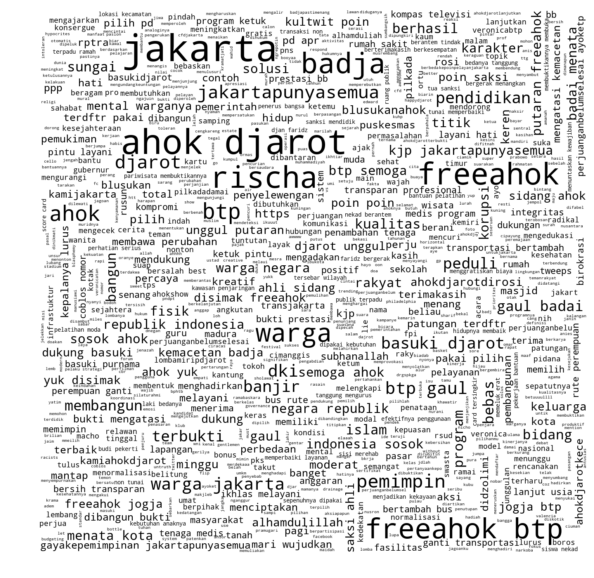

In [ ]:
wordcloud(normalized_pos) #Wordcloud positif

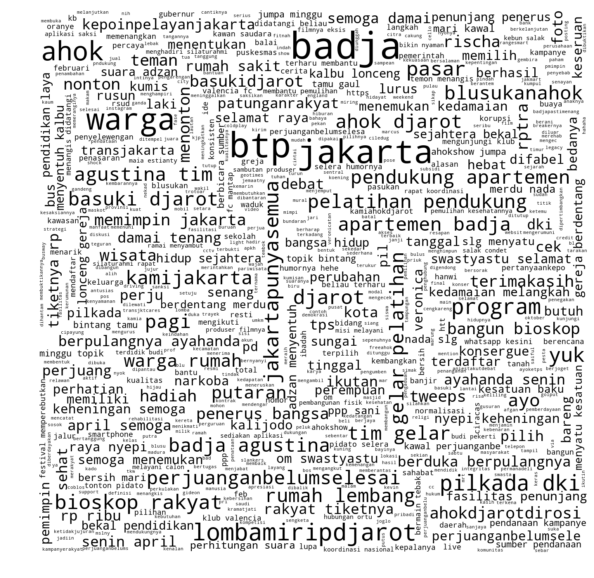

In [ ]:
wordcloud(normalized_neg) #Wordcloud Negatif

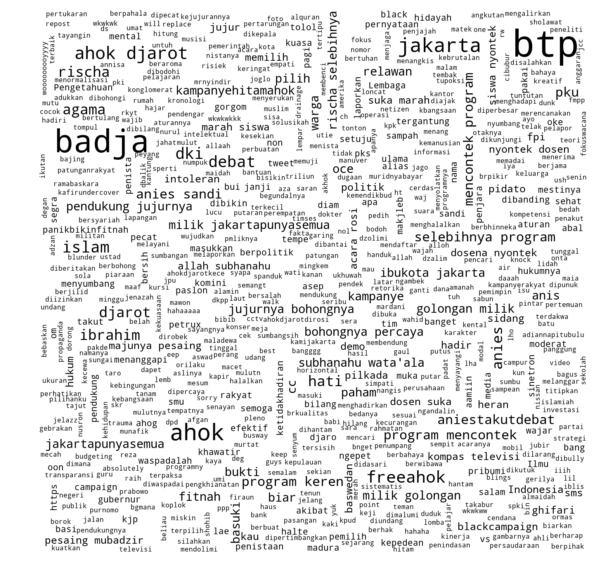

In [ ]:
wordcloud(normalized_netral) #Wordcloud Netral

# Naive Bayes Classification

In [ ]:
clean_df.head()

,isi,sentimen
0,rt penasaran sama basukidjarot punya pertanyaa...,netral
1,melayani warga jakarta mulai dari lahir dengan...,positif
2,golongan sumbu pendek lo fpi piaraan kluarga c...,negatif
3,rt pak ahok itu didzolimi aku yakin pak ahok b...,positif
4,prof edward omar sharif h ahli pidana menurut ...,positif


In [ ]:
X=clean_df.isi
y=clean_df.sentimen

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
vect = CountVectorizer()

In [ ]:
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [ ]:
X_train_dtm = vect.fit_transform(X_train)

In [ ]:
X_test_dtm = vect.transform(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [ ]:
%time nb.fit(X_train_dtm, y_train)

CPU times: user 3.08 ms, sys: 2 ms, total: 5.08 ms
Wall time: 5.33 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred_class = nb.predict(X_test_dtm)

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.6102564102564103

In [ ]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[21,  2, 24],
       [ 5, 27, 25],
       [ 5, 15, 71]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     negatif       0.68      0.45      0.54        47
      netral       0.61      0.47      0.53        57
     positif       0.59      0.78      0.67        91

    accuracy                           0.61       195
   macro avg       0.63      0.57      0.58       195
weighted avg       0.62      0.61      0.60       195



# Decision Tree

In [ ]:
X=clean_df.isi
y=clean_df.sentimen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
vect = CountVectorizer()

In [ ]:
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_train_dtm = vect.fit_transform(X_train)

In [ ]:
X_test_dtm = vect.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

In [ ]:
%time clf.fit(X_train_dtm, y_train)

CPU times: user 25.1 ms, sys: 1 µs, total: 25.1 ms
Wall time: 29.7 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
y_pred_class = clf.predict(X_test_dtm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     negatif       0.59      0.55      0.57        47
      netral       0.49      0.65      0.56        57
     positif       0.75      0.63      0.68        91

    accuracy                           0.62       195
   macro avg       0.61      0.61      0.60       195
weighted avg       0.64      0.62      0.62       195



# SVM Classification

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC(kernel='linear') 

In [ ]:
%time clf.fit(X_train_dtm, y_train)

CPU times: user 42.4 ms, sys: 995 µs, total: 43.4 ms
Wall time: 47.5 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred_class = clf.predict(X_test_dtm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

     negatif       0.67      0.72      0.69        47
      netral       0.67      0.54      0.60        57
     positif       0.68      0.74      0.71        91

    accuracy                           0.68       195
   macro avg       0.67      0.67      0.67       195
weighted avg       0.68      0.68      0.67       195

